# Dollar currency analysis


We will do Dollar Exchange Rate analysis task with LSTM.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
import itertools

from math import sqrt
from datetime import datetime
from numpy import concatenate

import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, GRU
from keras.layers.recurrent import LSTM
from sklearn.utils import shuffle

import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

py.init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')

## Data pre-processing

In the data set, US dollar sales data of the Central Bank between 2000 and 2022 were used.


In [ ]:
# We load our dataset.

data = pd.read_excel('/content/drive/My Drive/DolarExchangeRatePrediction/EVDS.xlsx', date_parser=[0], index_col = 0, header = 0)

data.describe()

,TP DK USD S YTL
count,5569.000000
mean,2.709904
std,2.293769
min,0.537722
25%,1.399920
50%,1.656445
75%,3.009400
max,17.504600


In [ ]:
# Converting column name, to make more sense.

data = data.rename(columns = {"TP DK USD S YTL": "TL"})

data.head()

,TL
Tarih,
01-01-2000,NaN
02-01-2000,NaN
03-01-2000,0.542703
04-01-2000,0.543401
05-01-2000,0.538399


In [ ]:
data = data[data.index.notnull()]
data.head()

,TL
Tarih,
01-01-2000,NaN
02-01-2000,NaN
03-01-2000,0.542703
04-01-2000,0.543401
05-01-2000,0.538399


In [ ]:
print(data[['TL']])

                   TL
Tarih                
01-01-2000        NaN
02-01-2000        NaN
03-01-2000   0.542703
04-01-2000   0.543401
05-01-2000   0.538399
...               ...
17-02-2022  13.639900
18-02-2022  13.628000
19-02-2022        NaN
20-02-2022        NaN
21-02-2022  13.636300

[8088 rows x 1 columns]


As can be understood, the markets are closed on Saturday and Sunday, and that's why those data show NaN.

In [ ]:
# We fill the data in a linear fashion using the interpolate function.

data['TL'].interpolate(method="linear", inplace = True)

In [ ]:
data = data.iloc[2:]

data.head()

,TL
Tarih,
03-01-2000,0.542703
04-01-2000,0.543401
05-01-2000,0.538399
06-01-2000,0.537722
07-01-2000,0.537738


## Get Useful Statistics Out and Plot The Exchange Rates

In [ ]:
data.describe()

,TL
count,8086.000000
mean,2.712727
std,2.290902
min,0.537722
25%,1.401141
50%,1.656542
75%,3.012300
max,17.504600


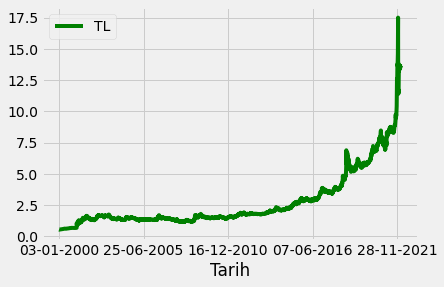

In [ ]:
data.plot(color = 'green')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ca0026650>]],
      dtype=object)

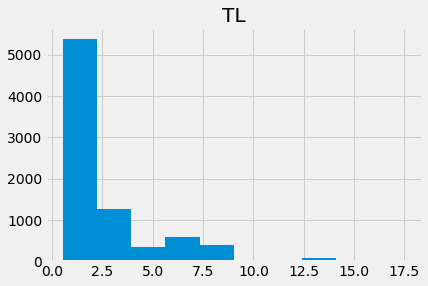

In [ ]:
data.hist()

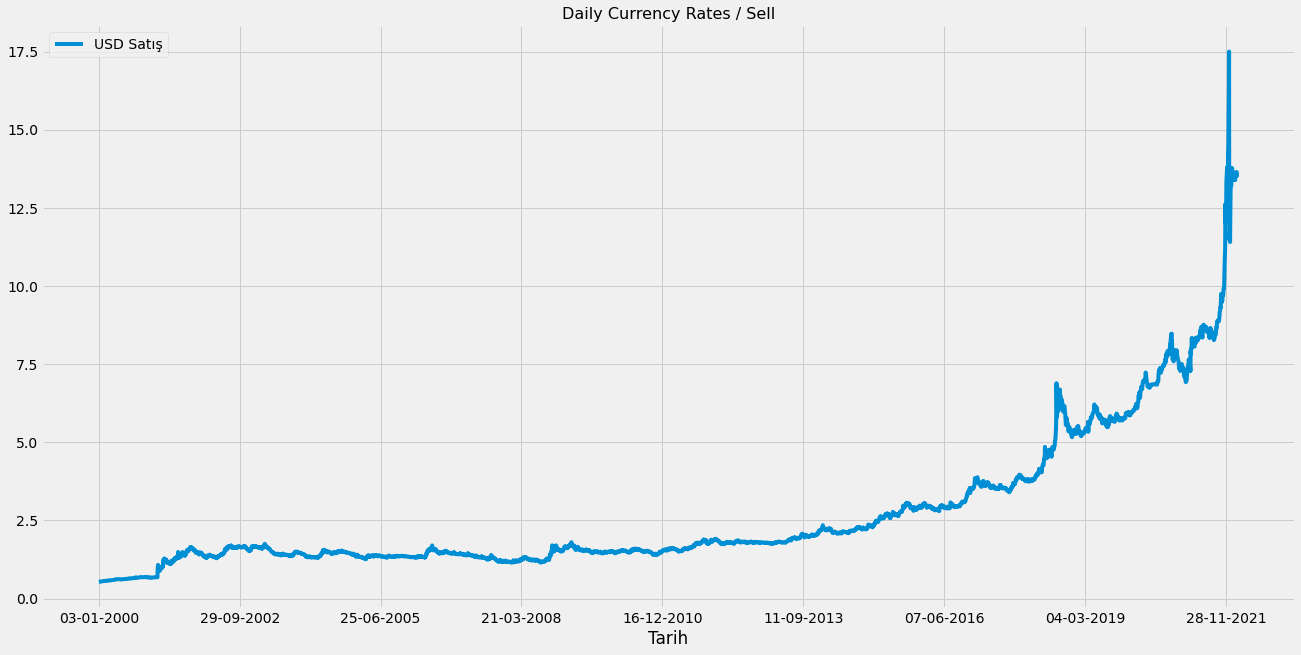

In [ ]:
fig = plt.figure(figsize = (20, 10))

data.TL.plot(label = "USD Satış")
plt.legend(loc = "best")
plt.title("Daily Currency Rates / Sell", fontsize = 16)
plt.show()

## LSTM Implementation
We will use LSTM for data forecasting.

### What is LSTM?
LSTM is an RNN architecture that remembers values at random intervals. Stored values are not changed when learned progress is made. RNNs allow forward and reverse connections between neurons.
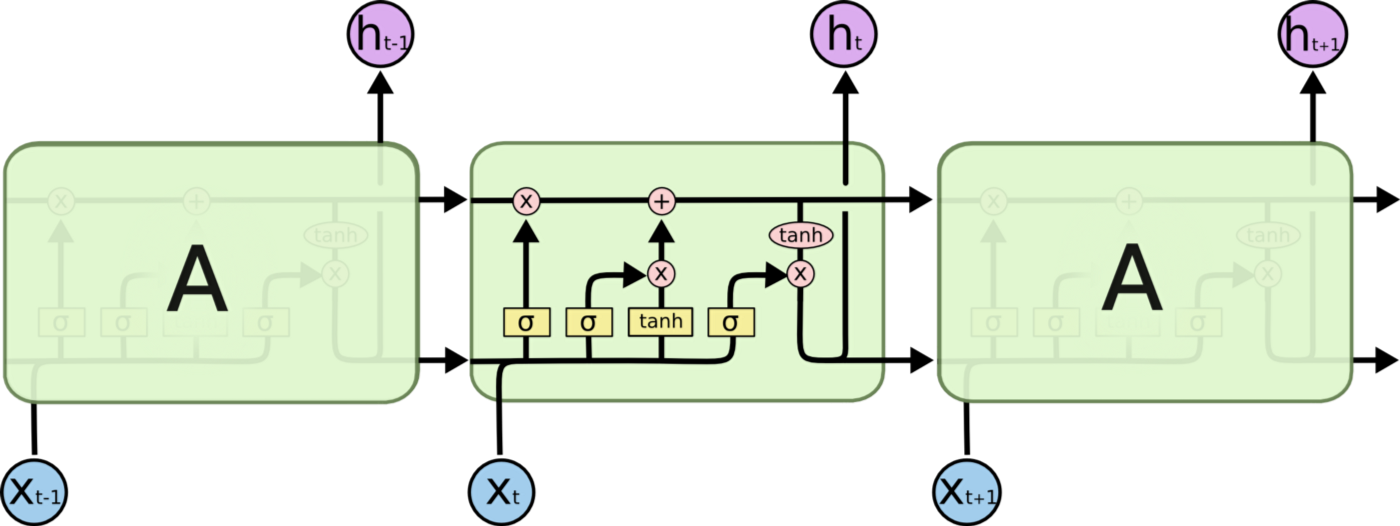
An LSTM is well-suited for classifying, processing and predicting time series given the time delays of unknown size and duration between significant events. The relative insensitivity to gap length gives LSTM an advantage over alternative RNNs, hidden Markov models and other sequence learning methods in countless applications.   

In [ ]:
# Before exporting the data to LSTM, we should scale it between 0-1.

values = data['TL'].to_numpy().reshape(-1, 1)
values = values.astype('float32')
scaler = MinMaxScaler()
dataset = scaler.fit_transform(values)

In [ ]:
# Take a look at few values.
dataset[1000:1010]

array([[0.065938  ],
       [0.06594606],
       [0.06605186],
       [0.06638852],
       [0.06526492],
       [0.06486938],
       [0.06487394],
       [0.0648785 ],
       [0.06488305],
       [0.06539086]], dtype=float32)

In [ ]:
# Split the data.
# %80 train, %20 test.

TRAIN_SIZE = 0.8

train_size = int(len(data) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Day Counts: (training set, test set): " + str((len(train), len(test))))

Day Counts: (training set, test set): (6468, 1618)


In [ ]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [ ]:
# Create Datasets.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Look at new dataset shape.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(6466, 1)
New training data shape:
(6466, 1, 1)


In [ ]:
# Let's construct the LSTM model.

def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    # The LSTM model will have one layer.
    model.add(LSTM(100, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 30, 
              batch_size = 1, 
              verbose = 1)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/30
6466/6466 [==============================] - 23s 3ms/step - loss: 8.5746e-05
Epoch 2/30
6466/6466 [==============================] - 20s 3ms/step - loss: 2.2845e-06
Epoch 3/30
6466/6466 [==============================] - 19s 3ms/step - loss: 2.2748e-06
Epoch 4/30
6466/6466 [==============================] - 22s 3ms/step - loss: 1.9508e-06
Epoch 5/30
6466/6466 [==============================] - 22s 3ms/step - loss: 1.8896e-06
Epoch 6/30
6466/6466 [==============================] - 20s 3ms/step - loss: 1.8926e-06
Epoch 7/30
6466/6466 [==============================] - 20s 3ms/step - loss: 1.8508e-06
Epoch 8/30
6466/6466 [==============================] - 20s 3ms/step - loss: 1.6846e-06
Epoch 9/30
6466/6466 [==============================] - 21s 3ms/step - loss: 1.6826e-06
Epoch 10/30
6466/6466 [==============================] - 20s 3ms/step - loss: 1.7340e-06
Epoch 11/30
6466/6466 [==============================] - 19s 3ms/step - loss: 1.5917e-06
Epoch 12/30
6466/6466 [=======

In [ ]:
def predict_and_score(model, X, Y):
    # Transform back.
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)
rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)
print("Training data score: %.4f RMSE" % rmse_train)
print("Test data score: %.4f RMSE" % rmse_test)

Training data score: 0.0146 RMSE
Test data score: 0.4404 RMSE


## Conclusion

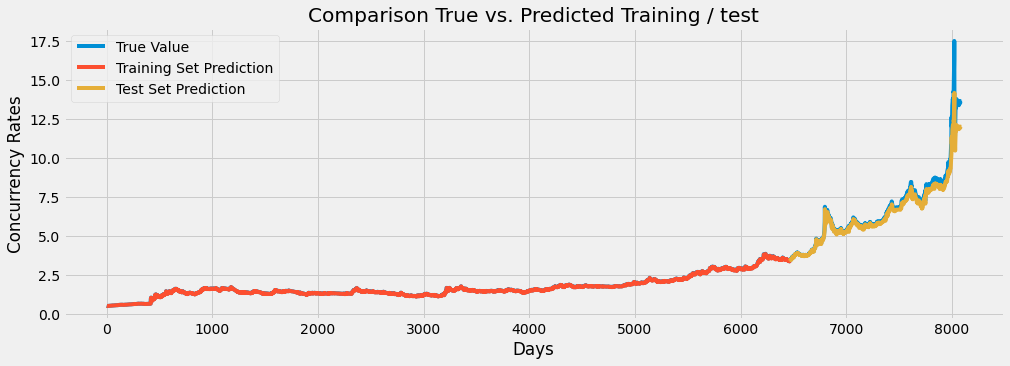

In [ ]:
# Train Prediction.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Test Prediction.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Creating plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True Value")
plt.plot(train_predict_plot, label = "Training Set Prediction")
plt.plot(test_predict_plot, label = "Test Set Prediction")
plt.xlabel("Days")
plt.ylabel("Concurrency Rates")
plt.title("Comparison True vs. Predicted Training / test")
plt.legend()
plt.show()
